In [2]:
import sys
import astro_models
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from astropy.timeseries import LombScargle
import astropy.units as u
import scipy.signal as signal

In [3]:
def linear_slope(time, a, b):
    return a*time + b

def degree2_slope(time, a, b, c):
    return a*time**2 + b*time + c

In [5]:
# load decorrelated data for various apertures
# apertures 4 to 12
aperture = ['4', '5', '6', '7', '8', '9', '10', '11', '12']
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time = {a: [] for a in aperture}
aplev = {a: [] for a in aperture}
aperr = {a: [] for a in aperture}

for a in aperture:
    for seg in segments:
        path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time[a] = np.append(time[a], np.array(file['time']))
            aplev[a] = np.append(aplev[a], np.array(file['aplev']))
            aperr[a] = np.append(aperr[a], np.array(file['aperr']))

    time[a] = np.array(time[a])
    aplev[a] = np.array(aplev[a])
    aperr[a] = np.array(aperr[a])
    
print(time['4'])
print(time['7'])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]
[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


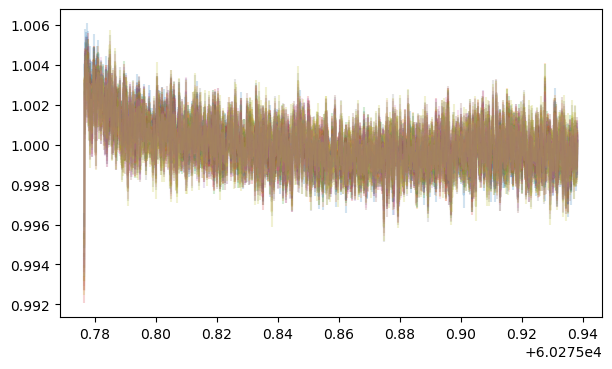

In [6]:
# normalize the fluxes
norm_aplev = {a: [] for a in aperture}
norm_aperr = {a: [] for a in aperture}
plt.figure(figsize=[7,4])
for ap in aperture:
    norm_aplev[ap] = aplev[ap] / np.mean(aplev[ap])
    norm_aperr[ap] = aperr[ap] / (np.mean(aplev[ap])) 
    plt.errorbar(time[ap], norm_aplev[ap], yerr=norm_aperr[ap], alpha=0.2)

# plot flux & uncertainties
# plt.figure(figsize=[7,4])
# plt.errorbar(time['7'], norm_aplev['7'], yerr=norm_aperr['7'], color = 'blue', alpha=0.3)
# #plt.figure(figsize=[15,4])
# plt.errorbar(time['4'], norm_aplev['4'], yerr=norm_aperr['4'], color = 'orange', alpha=0.3)
# plt.errorbar(time['12'], norm_aplev['12'], yerr=norm_aperr['12'], color = 'green', alpha=0.3)
#plt.savefig('LHS1140_c.pdf')

<ErrorbarContainer object of 3 artists>

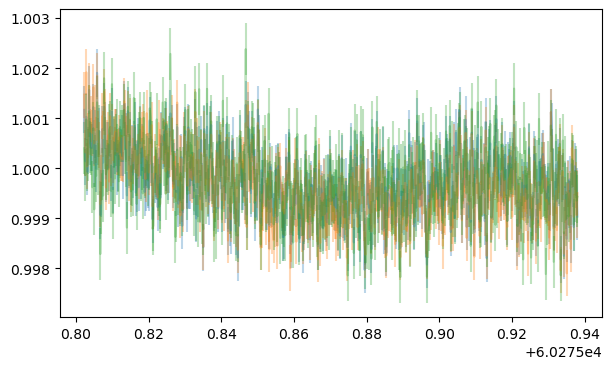

In [ ]:
# bin the data and remove first 200 pts
nbin = 500
bins_time = {a: [] for a in aperture}
bins_aplev = {a: [] for a in aperture}
bins_aperr = {a: [] for a in aperture}

for a in aperture:
    bins_time[a], binErr_t = binValues(time[a][200:], time[a][200:], nbin)
    bins_aplev[a], binErr_aplev = binValues(norm_aplev[a][200:], time[a][200:], nbin)
    bins_aperr[a], err = binValues(norm_aperr[a][200:], time[a][200:], nbin, errorbars=True)

plt.figure(figsize=[7,4])
plt.errorbar(bins_time['7'], bins_aplev['7'], bins_aperr['7'], alpha=0.3)
#plt.figure(figsize=[7,4])
plt.errorbar(bins_time['4'], bins_aplev['4'], yerr=bins_aperr['4'], alpha=0.3)
plt.errorbar(bins_time['12'], bins_aplev['12'], yerr=bins_aperr['12'], alpha=0.3)
#plt.figure()
#plt.errorbar(bins_time['7'], bins_aplev['7'], err, alpha=0.3)
#plt.errorbar(bins_time['4'], bins_aplev['4'], err, alpha=0.3)

In [ ]:
# remove eclipse
eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
#time = np.array(time)
eclipse.mjd
e_dur_days = 1.13 / 24
start = eclipse - e_dur_days / 2  # Center the rectangle at the start of the eclipse
start = start.mjd

short_time = {a: [] for a in aperture}

for a in aperture:
    # from full data
    # ind1 = np.abs(time[a] - start).argmin()
    # ind2 = np.abs(time[a] - (start + e_dur_days)).argmin()
    # time[a] = np.delete(time[a], np.arange(ind1,ind2))
    # aplev[a] = np.delete(aplev[a], np.arange(ind1,ind2))
    # aperr[a] = np.delete(aperr[a], np.arange(ind1,ind2))

    # from binned data
    ind1 = np.abs(bins_time[a] - start).argmin()
    ind2 = np.abs(bins_time[a] - (start + e_dur_days)).argmin()
    bins_time[a] = np.delete(bins_time[a], np.arange(ind1,ind2))
    bins_aplev[a] = np.delete(bins_aplev[a], np.arange(ind1,ind2))
    bins_aperr[a] = np.delete(bins_aperr[a], np.arange(ind1,ind2))

    # for normalized data with eclipse and first 200 pts removed
    ind1 = np.abs(norm_aplev[a] - start).argmin()
    ind2 = np.abs(norm_aplev[a] - (start + e_dur_days)).argmin()
    short_time[a] = np.delete(time[a], np.arange(ind1,ind2))
    norm_aplev[a] = np.delete(norm_aplev[a], np.arange(ind1,ind2))
    norm_aperr[a] = np.delete(norm_aperr[a], np.arange(ind1,ind2))
    short_time[a] = short_time[a][200:]
    norm_aplev[a] = norm_aplev[a][200:]
    norm_aperr[a] = norm_aperr[a][200:]


In [ ]:
# remove first 200 pts from all aperture (for raw data)

for a in aperture:
    time[a] = time[a][200:]
    aplev[a] = aplev[a][200:]
    aperr[a] = aperr[a][200:]

/var/folders/19/ynl_hkyx385cs4g05ztfqxfr0000gp/T/ipykernel_14075/1095624558.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(bins_time[ap], bins_aplev[ap]/degree2_slope(bins_time[ap], a, b, c), 'ok', markersize=4, label='Binned Data', color = 'red')
/var/folders/19/ynl_hkyx385cs4g05ztfqxfr0000gp/T/ipykernel_14075/1095624558.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(bins_time[ap], degree2_slope(bins_time[ap], a, b, c), 'k', label='Quadratic Fit', color = 'black', markersize=4)


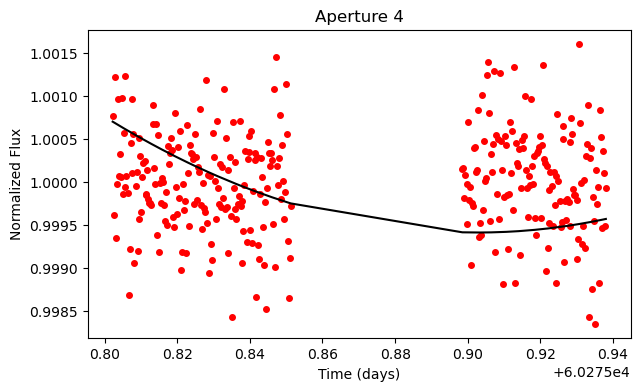

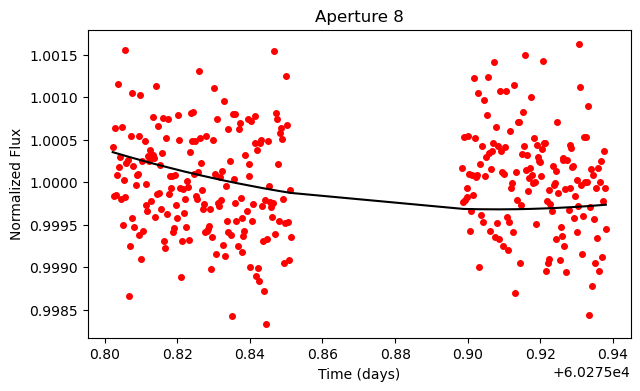

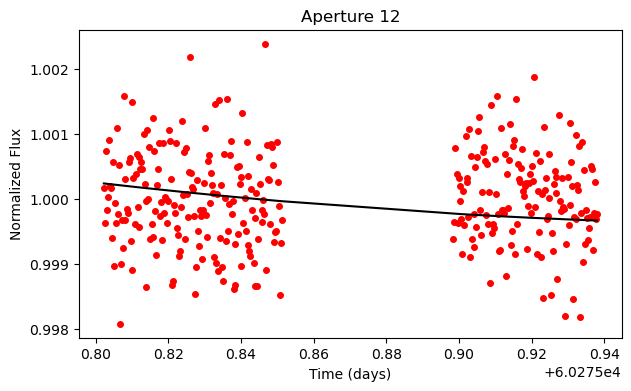

In [ ]:
# fit a quadratic to the binned data

for ap in aperture:
    plt.figure(figsize = [7,4])
    a, b, c = np.polyfit(bins_time[ap], bins_aplev[ap], 2)
    plt.plot(bins_time[ap], bins_aplev[ap]/degree2_slope(bins_time[ap], a, b, c), 'ok', markersize=4, label='Binned Data', color = 'red')
    plt.plot(bins_time[ap], degree2_slope(bins_time[ap], a, b, c), 'k', label='Quadratic Fit', color = 'black', markersize=4)
    plt.title('Aperture ' + ap)
    plt.xlabel('Time (days)')
    plt.ylabel('Normalized Flux')
    plt.savefig('figs/quadratic_fit_ap' + ap + '.png')
    

In [ ]:
residuals = {a: [] for a in aperture}
raw = {a: [] for a in aperture} # raw is normalized
power = {a: [] for a in aperture}
frequency = {a: [] for a in aperture}
power_full = {a: [] for a in aperture}
frequency_full = {a: [] for a in aperture}
dt = (short_time['4'][2]-short_time['4'][1])*24*60*60 # in seconds

# unbinned
for ap in aperture:
    t = short_time[ap]
    a, b, c = np.polyfit(short_time[ap], norm_aplev[ap], 2)
    residuals[ap] = norm_aplev[ap]/degree2_slope(short_time[ap], a, b, c)
    raw[ap] = aplev[ap] / np.mean(aplev[ap])

# binned
    # t = bins_time[ap]
    # a, b, c = np.polyfit(bins_time[ap], bins_aplev[ap], 2)
    # residuals = bins_aplev[ap]/degree2_slope(bins_time[ap], a, b, c)

/var/folders/19/ynl_hkyx385cs4g05ztfqxfr0000gp/T/ipykernel_14075/3385922989.py:12: RankWarning: Polyfit may be poorly conditioned
  a, b, c = np.polyfit(short_time[ap], norm_aplev[ap], 2)
/var/folders/19/ynl_hkyx385cs4g05ztfqxfr0000gp/T/ipykernel_14075/3385922989.py:12: RankWarning: Polyfit may be poorly conditioned
  a, b, c = np.polyfit(short_time[ap], norm_aplev[ap], 2)
/var/folders/19/ynl_hkyx385cs4g05ztfqxfr0000gp/T/ipykernel_14075/3385922989.py:12: RankWarning: Polyfit may be poorly conditioned
  a, b, c = np.polyfit(short_time[ap], norm_aplev[ap], 2)


In [ ]:
# Final plot, stack of 3 apertures
frequency = {a: [] for a in aperture}
power = {a: [] for a in aperture}
frequency_full = {a: [] for a in aperture}
power_full = {a: [] for a in aperture}
period = {a: [] for a in aperture}
period_full = {a: [] for a in aperture}

# period in seconds
for ap in aperture:
    frequency[ap], power[ap] = LombScargle(t, residuals[ap]).autopower()
    frequency_full[ap], power_full[ap] = LombScargle(time[ap], raw[ap]).autopower()
    period[ap] = (1/frequency[ap])*(24*60*60)
    period_full[ap] = (1/frequency_full[ap])*(24*60*60)

In [ ]:
fig, ax = plt.subplots(2,2)
#adjust figsize
fig.set_figheight(10)
fig.set_figwidth(16)

# residuals
peak_indices, z = signal.find_peaks(np.array(power['4']), height = 0.1)
colors = ['c', 'limegreen', 'magenta']
c=0
for i in range(0,len(peak_indices)-1):
         if i == 0 or np.floor(period['4'][peak_indices[i]]) != np.floor(period['4'][peak_indices[i-1]]) :
            #color = colors[i % len(colors)]  # Cycle through colors
            label = f"Peak period {period['4'][peak_indices[i]]:.2f}s"           
            ax[0,0].axvline(x=period['4'][peak_indices[i]],linestyle='--', color = colors[c], label = label)
            ax[1,0].axvline(x=period['4'][peak_indices[i]],linestyle='--', color = colors[c], label = label)
            c+=1

ax[0,0].axvline(x=len(short_time['4'])*dt, color='red', label=f"Observation duration {len(short_time['4'])*dt/(60*60):.2f}hours")
ax[1,0].axvline(x=len(time['4'])*dt, color='red', label=f"Observation duration {len(time['4'])*dt/(60*60):.2f}hours")


ax[0,0].plot(period[ap], power['4'], label = '4', color = 'orange') # convert frequency to period in seconds
ax[0,0].plot(period[ap], power['8'], label = '8', color = 'blue') # convert frequency to period in seconds
ax[0,0].plot(period[ap], power['12'], label = '12', color = 'green') # convert frequency to period in seconds
ax[0,0].set_xscale('log')
ax[0,0].set_title('Residuals Periodogram')
ax[0,0].set_ylim(0,0.6)
ax[0,0].set_xlabel('Period (s)')
ax[0,0].set_ylabel('Power')

#full
ax[1,0].plot(period_full[ap], power_full['4'], label = '4', color = 'orange') 
ax[1,0].plot(period_full[ap], power_full['8'], label = '8', color = 'blue') 
ax[1,0].plot(period_full[ap], power_full['12'], label = '12', color = 'green')

ax[1,0].set_xscale('log')
ax[1,0].set_title('Full data Periodogram')
ax[1,0].set_ylim(0, 0.6)
ax[1,0].set_xlabel('Period (s)')
ax[1,0].set_ylabel('Power')

# residuals histogram
ax[0,1].hist(residuals['4'], bins=50, alpha=0.5, label='4')
ax[0,1].hist(residuals['8'], bins=50, alpha=0.5, label='8')
ax[0,1].hist(residuals['12'], bins=50, alpha=0.5, label='12')

ax[0,1].axvline(x=np.mean(residuals['4']), color='orange', linestyle='dashed', linewidth=1, label='Mean 4')
ax[0,1].axvline(x=np.mean(residuals['8']), color='blue', linestyle='dashed', linewidth=1, label='Mean 8')
ax[0,1].axvline(x=np.mean(residuals['12']), color='green', linestyle='dashed', linewidth=1, label='Mean 12')

ax[0,1].axvline(x=np.mean(residuals['4'])+np.std(residuals['4']), color='orange', linestyle='dotted', linewidth=1, label='1$\sigma$ 4')
ax[0,1].axvline(x=np.mean(residuals['8'])+np.std(residuals['8']), color='blue', linestyle='dotted', linewidth=1, label='1$\sigma$ 8')
ax[0,1].axvline(x=np.mean(residuals['12'])+np.std(residuals['12']), color='green', linestyle='dotted', linewidth=1, label='1$\sigma$ 12')
ax[0,1].axvline(x=np.mean(residuals['4'])-np.std(residuals['4']), color='orange', linestyle='dotted', linewidth=1)
ax[0,1].axvline(x=np.mean(residuals['8'])-np.std(residuals['8']), color='blue', linestyle='dotted', linewidth=1)
ax[0,1].axvline(x=np.mean(residuals['12'])-np.std(residuals['12']), color='green', linestyle='dotted', linewidth=1)

ax[0,1].set_title('Residuals Histogram')
ax[0,1].set_xlabel('Normalized Flux')
ax[0,1].set_xlim(0.996, 1.004)

#full residuals histogram
ax[1,1].hist(raw['4'], bins=50, alpha=0.5, label='4')
ax[1,1].hist(raw['8'], bins=50, alpha=0.5, label='8')
ax[1,1].hist(raw['12'], bins=50, alpha=0.5, label='12')

ax[1,1].axvline(x=np.mean(raw['4']), color='orange', linestyle='dashed', linewidth=1, label='Mean 4')
ax[1,1].axvline(x=np.mean(raw['8']), color='blue', linestyle='dashed', linewidth=1, label='Mean 8')
ax[1,1].axvline(x=np.mean(raw['12']), color='green', linestyle='dashed', linewidth=1, label='Mean 12')

ax[1,1].axvline(x=np.mean(raw['4'])+np.std(raw['4']), color='orange', linestyle='dotted', linewidth=1, label='1$\sigma$ 4')  
ax[1,1].axvline(x=np.mean(raw['8'])+np.std(raw['8']), color='blue', linestyle='dotted', linewidth=1, label='1$\sigma$ 8')
ax[1,1].axvline(x=np.mean(raw['12'])+np.std(raw['12']), color='green', linestyle='dotted', linewidth=1, label='1$\sigma$ 12')
ax[1,1].axvline(x=np.mean(raw['4'])-np.std(raw['4']), color='orange', linestyle='dotted', linewidth=1)  
ax[1,1].axvline(x=np.mean(raw['8'])-np.std(raw['8']), color='blue', linestyle='dotted', linewidth=1)
ax[1,1].axvline(x=np.mean(raw['12'])-np.std(raw['12']), color='green', linestyle='dotted', linewidth=1)

ax[1,1].set_title('Full data Histogram')
ax[1,1].set_xlim(0.996, 1.004)
ax[1,1].set_xlabel('Normalized Flux')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.savefig('figs/comparison-ap-4-8-12.png')

# duration of observation is for considered observation i.e. first 36 mins ignored

NameError: name 'plt' is not defined

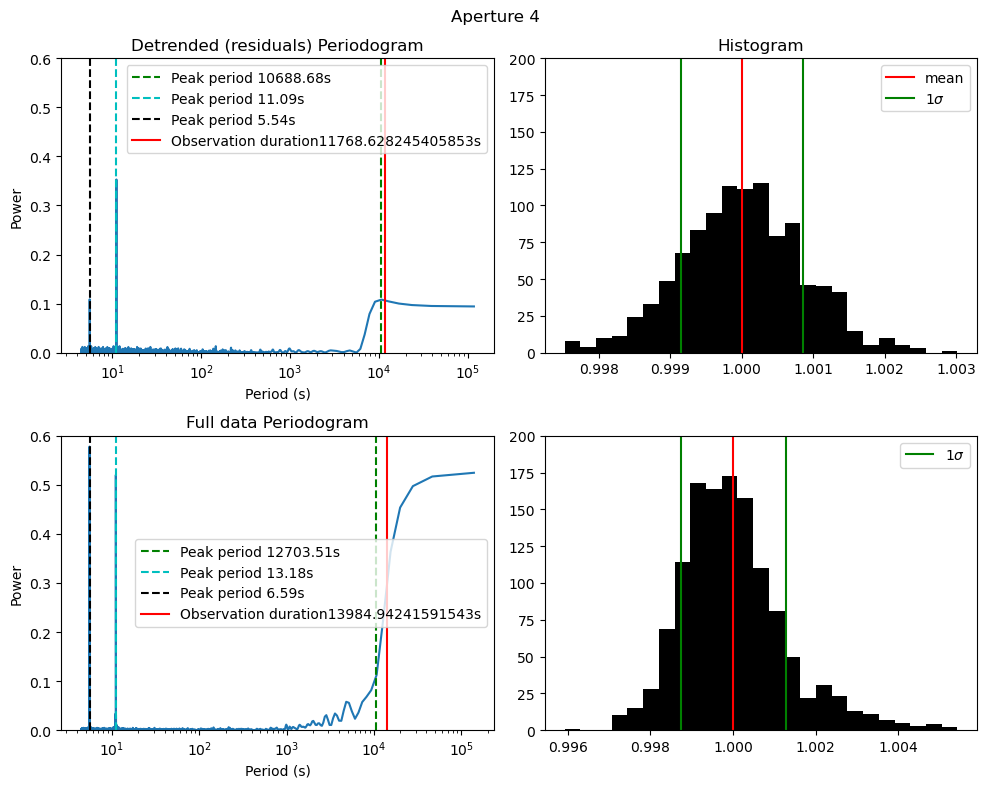

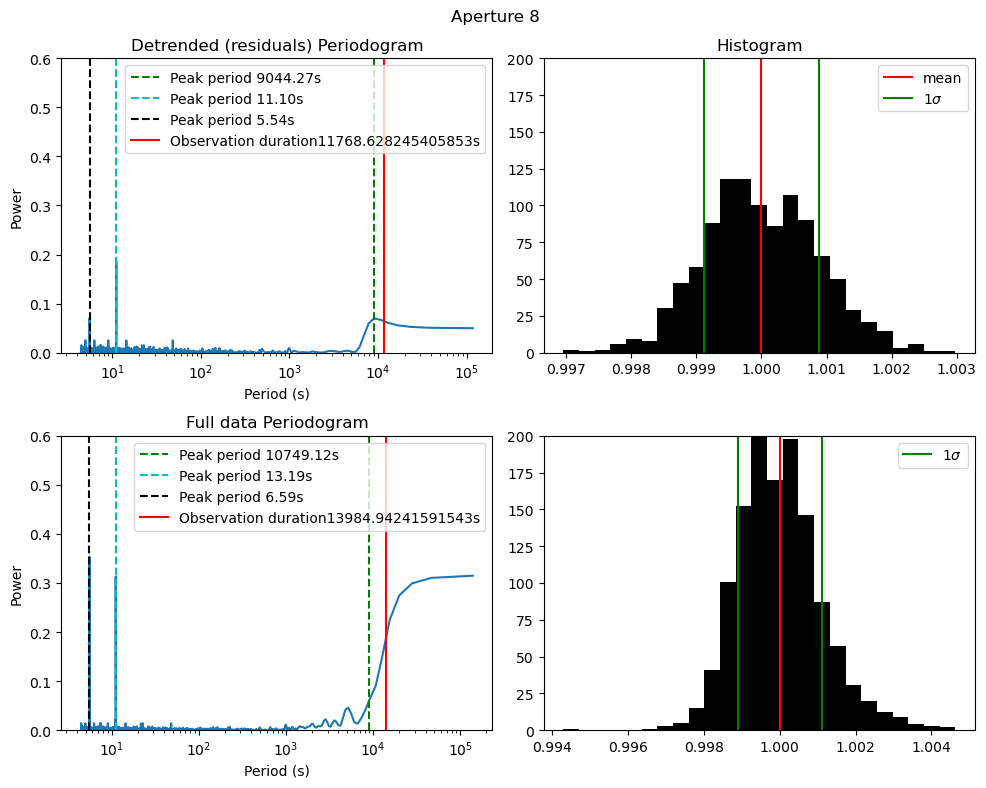

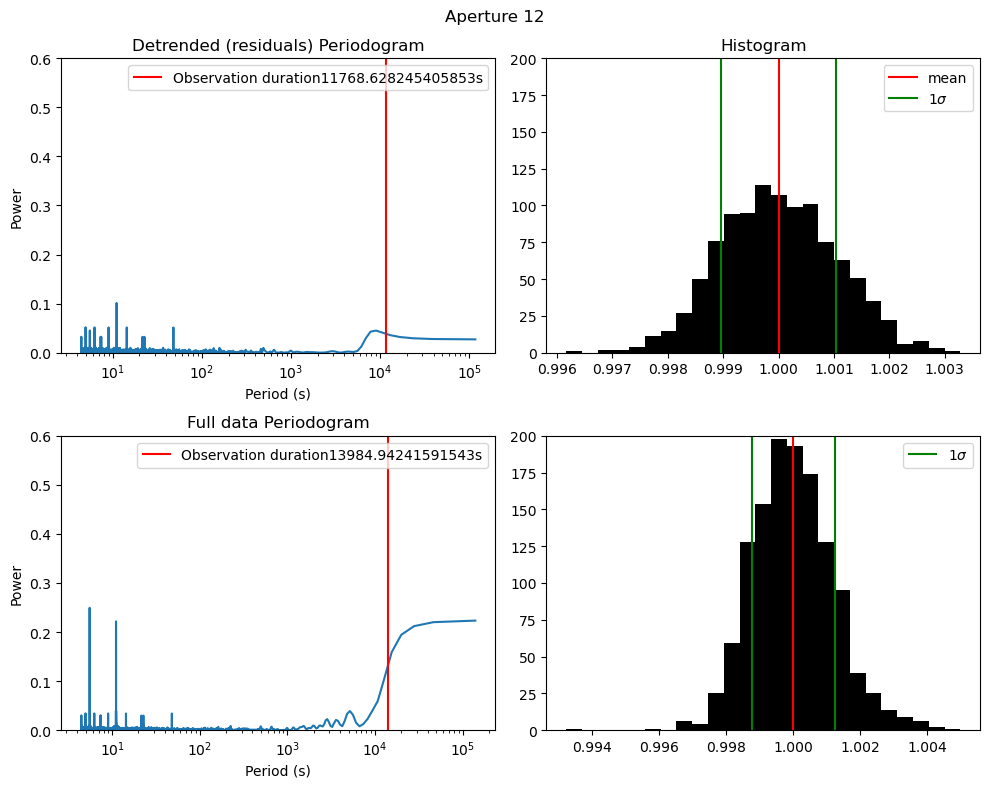

In [ ]:
# stats on residuals compared to full data
# residuals are defined as normalized, first 200 pts removed, eclipse removed, trend removed
aperture = ['4', '8', '12']

np.set_printoptions(suppress=True)

for ap in aperture:
    t = short_time[ap]
    # plot periodogram and histogram
    fig, ax = plt.subplots(2,2)
    #adjust figsize
    fig.set_figheight(8)
    fig.set_figwidth(10)
    # add title
    fig.suptitle('Aperture ' + ap)

    # periodogram
    ax[0,0].plot(period[ap], power[ap])

    # Colors to cycle through
    colors = ['g', 'c', 'm', 'y', 'k']

    # identify peaks
    peak_indices, z = signal.find_peaks(np.array(power[ap]), height = 0.06)
    for i in range(0,len(peak_indices)-1):
         if i == 0 or np.floor(period[ap][peak_indices[i]]) != np.floor(period[ap][peak_indices[i-1]]) :
            color = colors[i % len(colors)]  # Cycle through colors
            label = f'Peak period {period[ap][peak_indices[i]]:.2f}s'
            ax[0,0].axvline(x=period[ap][peak_indices[i]],linestyle='--', color = color, label = label)

    ax[0,0].axvline(x=len(t)*dt, color='red', label = 'Observation duration'+str(len(t)*dt)+'s')
    # ax[0,0].axvline(x=period[ap][5305], color='green', label = 'Peak period 11s', linestyle='--')
    # ax[0,0].axvline(x=period[ap][10604], color='lightblue', label = 'Peak period 5.54s', linestyle='--')
    #ax[0,0].axvline(x=1/390)
    ax[0,0].set_xscale('log')
    #ax[0,0].plot(frequency, power)
    ax[0,0].set_title('Detrended (residuals) Periodogram')
    ax[0,0].set_ylim(0, 0.6)
    ax[0,0].set_xlabel('Period (s)')
    ax[0,0].set_ylabel('Power')
    ax[0,0].legend()
    #ax[0,0].set_xlim(0,500)

    # histogram
    ax[0,1].hist(residuals[ap], bins = 25, color = 'black')
    ax[0,1].axvline(x=np.mean(residuals[ap]), color='red', label='mean')
    ax[0,1].axvline(x=np.mean(residuals[ap])+np.std(residuals[ap]), color='green', label='1$\sigma$')
    ax[0,1].axvline(x=np.mean(residuals[ap])-np.std(residuals[ap]), color='green')
    ax[0,1].set_title('Histogram')
    # set ylim
    ax[0,1].set_ylim(0, 200)
    ax[0,1].legend()

    # Compare with full data
    ax[0,0].set_ylabel('Power')
    ax[1,0].set_ylabel('Power')
    # ax[1,0].set_ylabel('Full signal')
    # ax[0,0].set_title('Detrended flux')

    # raw / full
    t = time[ap]
    raw[ap] = aplev[ap] / np.mean(aplev[ap])

    # periodogram
    ax[1,0].plot(period_full[ap])*(24*60*60), power_full[ap]) #/0.00012825)
    
    # Colors to cycle through
    colors = ['g', 'c', 'm', 'y', 'k']

    # identify peaks
    peak_indices, z = signal.find_peaks(np.array(power[ap]), height = 0.06)
    for i in range(0,len(peak_indices)-1):
         if i == 0 or np.floor(period[ap][peak_indices[i]]) != np.floor(period[ap][peak_indices[i-1]]) :
            color = colors[i % len(colors)]  # Cycle through colors
            label = f'Peak period {period_full[ap][peak_indices[i]]:.2f}s'
            ax[1,0].axvline(x=period[ap][peak_indices[i]],linestyle='--', color = color, label = label)

    ax[1,0].axvline(x=len(t)*dt, color='red', label = 'Observation duration'+str(len(t)*dt)+'s')
    ax[1,0].set_xscale('log')
    ax[1,0].set_xlabel('Period (s)')
    #ax[1,0].set_xlim(0.001,0.001)
    #set y limits
    ax[1,0].set_ylim(0, 0.6)
    ax[1,0].set_title('Full data Periodogram')
    ax[1,0].legend()
    # frequencies of oscillation (i.e., number of cycles per unit time).

    # histogram
    ax[1,1].hist(raw[ap], bins = 25, color = 'black')
    ax[1,1].axvline(x=np.mean(raw[ap]), color='red')
    ax[1,1].axvline(x=np.mean(raw[ap])+np.std(raw[ap]), color='green', label = '1$\sigma$')
    ax[1,1].axvline(x=np.mean(raw[ap])-np.std(raw[ap]), color='green')
    ax[1,1].legend()

    # set ylim
    ax[1,1].set_ylim(0, 200)
    plt.tight_layout()
    #save fig
    plt.savefig('figs/Aperture' + ap + '.png')

# std deviation and comparison with other apertures
# use boxcar to smooth data (convolve with boxcar) to remove all signal and see scatter and use that as residuals
# 390 hz
# intervale ch point
# duree des observations
# inclure psf image + print out
# stack all ap in one plot

6
[ 1222  4082  5305  6527  9387 11832]
max frequency value:  5305
The indices of the peaks are: [1222 5305 9387] 
This corresponds to the following frequencies: [ 1796.70137048  7797.46349372 13796.75592259] 
These frequencies correspond to the following periods (s): [48.08812495 11.08052639  6.2623417 ]


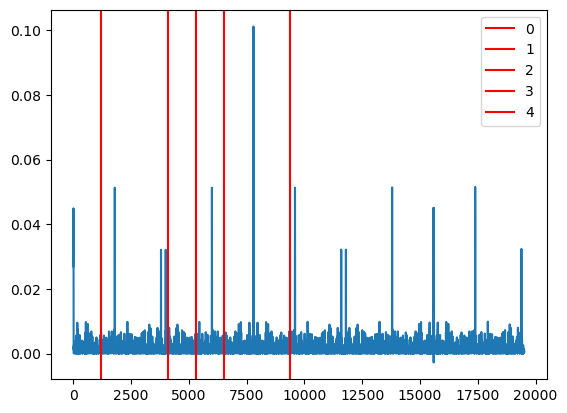

In [ ]:
f = frequency['12']#[:200]
x = np.array(f) # convert your 1-D array to a numpy array if it's not, otherwise omit this line
y = np.array(power['12']) # convert your 1-D array to a numpy array if it's not, otherwise omit this line
peak_indices, z = signal.find_peaks(y, height = 0.05)
peak_count = len(peak_indices) # the number of peaks in the array
print(peak_count)
print(peak_indices)

plt.plot(frequency['12'], power['12'])

for i in range(0,len(peak_indices)-1):  
    plt.axvline(x=peak_indices[i], color = 'red', label = i)

# for i in range(0,len(peak_indices)-1):
#     plt.axvline(x=x[peak_indices[i]], color = 'green')
# #plt.xlim(-20, 50)
#plt.xlim(7600, 8000)
#plt.axvline(x=x[peak_indices], color = 'green')
#plt.axvline(x[5305], color = 'red')
plt.legend()

print('max frequency value: ',np.argmax(y))
#peaks = peak_indices[[0,2,4]]
np.set_printoptions(suppress=True)
print('The indices of the peaks are:', peaks, '\nThis corresponds to the following frequencies:', x[peaks], '\nThese frequencies correspond to the following periods (s):', (1/x[peaks])*(24*60*60))

# At around 10688, the peaks aren't well constrained corresponding to the duration of observations

In [ ]:
print('max frequency value: ',np.argmax(y))
peaks = peak_indices[[0,2,4]]
np.set_printoptions(suppress=True)
print('The indices of the peaks are:', peaks, '\nThis corresponds to the following frequencies:', x[peaks], '\nThese frequencies correspond to the following periods (s):', (1/x[peaks])*(24*60*60))

5305
The indices of the peaks are: [    5  5305 10604] 
This corresponds to the following frequencies: [    8.08331905  7797.46349372 15585.37397402] 
These frequencies correspond to the following periods (s): [10688.67868189    11.08052639     5.54365908]


5.54365908344667
0.002857142857142857


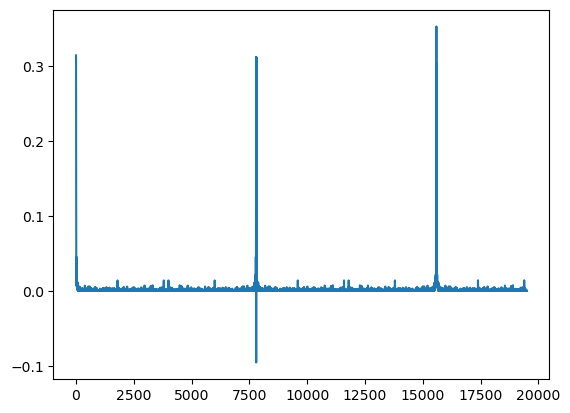

In [ ]:
print(period['4'][10604])
#label = 'Peak period ' + str(period[ap][peak_indices[i]]) + 's'
print(1/350)
plt.plot(frequency_full['8'], power_full['8'])

In [ ]:
print('Residuals:')
for ap in aperture:
    print('Aperture: ', ap, '\n mean: ', np.mean(residuals[ap]), '\n std: ', np.std(residuals[ap]))
    print(' Noise ratio: ' , np.std(residuals[ap])/np.mean(norm_aperr[ap]))

print('\nRaw:')
for ap in aperture:
    print('Aperture: ', ap, '\n mean: ', np.mean(raw[ap]), '\n std: ', np.std(raw[ap]))
    print(' Mean errorbar: ', np.mean(norm_aperr[ap]), ' \n Std errorbar: ', np.std(norm_aperr[ap]), '\n')

# these are all normalized, residuals are normalized before removing eclipse
# errorbars are calculated at each point but have very small
# Standard deviation of residuals is higher than errorbars

Residuals:
Aperture:  4 
 mean:  1.0000000000244904 
 std:  0.0008558676513334198
 Noise ratio:  1.2835943508461207
Aperture:  5 
 mean:  1.0000000000101406 
 std:  0.0008459031752923195
 Noise ratio:  1.2761891859753534
Aperture:  6 
 mean:  1.0000000000070268 
 std:  0.0008668216588924773
 Noise ratio:  1.2783701495580815
Aperture:  7 
 mean:  1.000000000006963 
 std:  0.0008789057180248371
 Noise ratio:  1.2784780079129856
Aperture:  8 
 mean:  1.0000000000055949 
 std:  0.0008843538384293633
 Noise ratio:  1.285247991637901
Aperture:  9 
 mean:  1.000000000005177 
 std:  0.000953071461344494
 Noise ratio:  1.3749792189942778
Aperture:  10 
 mean:  1.0000000000063378 
 std:  0.0009500678479668648
 Noise ratio:  1.3432155407675108
Aperture:  11 
 mean:  1.000000000005752 
 std:  0.0009960081568721124
 Noise ratio:  1.3647598749759131
Aperture:  12 
 mean:  1.0000000000046576 
 std:  0.001043985143175808
 Noise ratio:  1.3785351351082693

Raw:
Aperture:  4 
 mean:  1.0 
 std:  0.00127

Text(0.5, 0, 'Frequency (cycles/0.00012825 days)')

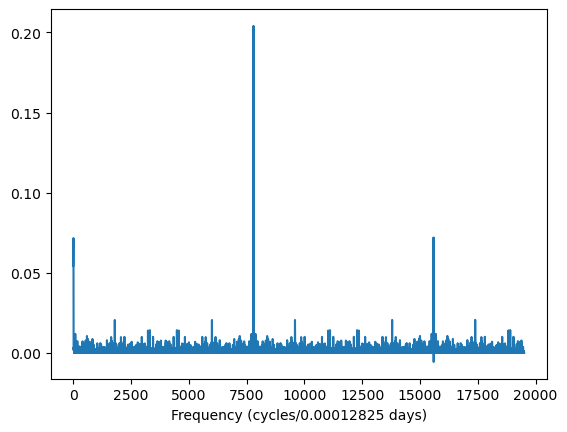

In [ ]:
frequency, power = LombScargle(short_time[ap], residuals[ap]).autopower()
plt.plot(frequency, power)  
plt.xlabel('Frequency (cycles/0.00012825 days)')

# 0.00012825 days is equivalent to 11s

In [ ]:
print(t[501]-t[500])
print(0.00012825 * 24 * 60 * 60) # every ~11 seconds
print((t[-1]-t[0])/len(t))
print(len(short_time['7'])) 
# unit is per 0.00012825 days

0.0001282589219044894
11.0808
0.0001281572903772405
1062


In [ ]:
print('4 mean error: ', np.mean(norm_aperr['4']))
print('7 mean error', np.mean(norm_aperr['7']))
print('4 std: ', np.std(norm_aperr['4']))
print('7 std: ', np.std(norm_aperr['7']))

# check to verify array with eclipse gives same OOM
# test = aperr['4'] / np.mean(aplev['4'])
# print(np.mean(test))
# print(np.std(test))
len(time['4'])
print((11*1262))


4 mean error:  0.0006667742427888127
7 mean error 0.0006874625238642792
4 std:  2.9206476081306554e-07
7 std:  2.1699044704454027e-07
0.0006668677022191062
3.4415687365944937e-07


In [ ]:
    # strain = np.fft.fft(aplev)
    # freq = np.fft.fftfreq(len(aplev), d = t[1]-t[0])
    # ax[1,0].plot(freq, np.abs(strain))

# frequency[ap], power[ap] = LombScargle(t, residuals[ap]).autopower()
# period[ap] = (1/frequency[ap])*(24*60*60)
# ax[0,0].plot((24*60*60)/frequency[ap], power[ap]) 

# frequency_full[ap], power_full[ap] = LombScargle(t, raw[ap]).autopower()
# period_full[ap] = (1/frequency_full[ap])*(24*60*60)
# ax[1,0].plot((1/frequency_full[ap])*(24*60*60), power_full[ap]) #/0.00012825)

# # identify peaks
# peak_indices, z = signal.find_peaks(np.array(power_full['4']), height = 0.06)
# c=0
# for i in range(0,len(peak_indices)-1):
#     if i == 0 or np.floor(period_full['4'][peak_indices[i]]) != np.floor(period_full['4'][peak_indices[i-1]]) :
#         #color = colors[i % len(colors)]  # Cycle through colors
#         label = f"Peak period {period_full['4'][peak_indices[i]]:.2f}s"
#         ax[1,0].axvline(x=period_full['4'][peak_indices[i]],linestyle='--', color = colors[c], label = label)
#         c+=1

13882


In [ ]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=False, errorbars = False):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    if errorbars == True:
        binned = np.array([np.nanmean(values[digitized == i]) for i in range(1, nbin)])
        binned = binned/np.sqrt(len(values)/nbin)
    else:
        binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])    
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))

    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr